This notebook contains an adaptation of Dan Foreman-Mackey's ["Fitting a model to data" tutorial.](https://emcee.readthedocs.io/en/stable/tutorials/line/). That tutorial is a great introduction to using Markov Chain Monte Carlo to fit a line to data using the `emcee` package. I've used `emcee` for a number of projects, and am currently using it for my Master's thesis. Recently, however, I've aqdded `pyMC3`to my MCMC toolbox. I thought a nice way to explore the the differences between the two would be to recreate the tutorial linked above while using `pyMC3` rather than `emcee`.

That said, there are some important, and notable differences between the two tutorials. First, I am concerned here only with fitting a line to some data, and not considering that the uncertainty of the "measurements" may be underestimated. I leave that to a later tutorial. Secondly, 

Without further adieu, let's get started. First, let's import the necessary packages. I'll assume, for now, that you already have these installed, or can easily find out how to install them.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az

And now we'll generate some synthetic data to illustrate how to use MCMC. We'll start with a very simple model, simply a line of the form $y = mx+b$. We'll supply values of $m$ and $b$ that we can compare our "best fit" model from MCMC later on.

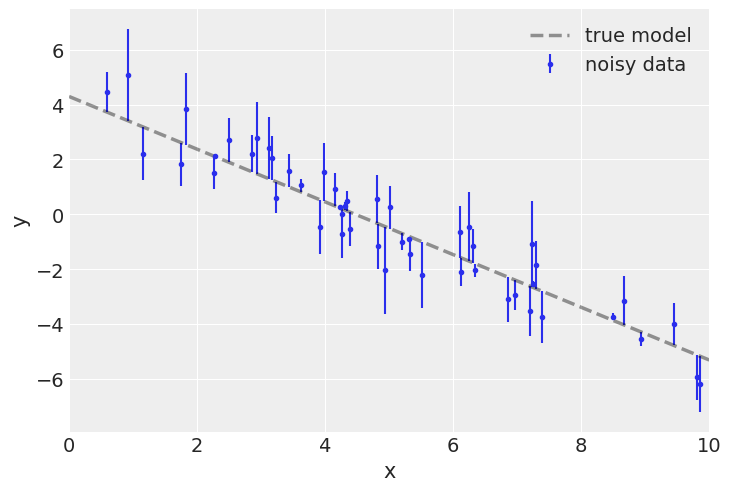

In [30]:
np.random.seed(123)
az.style.use("arviz-darkgrid")

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N)) # could use np.linspace or np.arange,if we wanted evenly spaced x data 
y = m_true * x + b_true
yerr = np.random.normal(scale=0.75, size=N) # generate errors from a normal 
                                           # distribution with stdev 0.75, centered on 0
y += yerr

plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0, label="noisy data")
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, 'k--', alpha=0.4, lw=2.5, label='true model')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

So now we have some synthetic data drawn from a random distribution centered on the true model, with the appropriate error bars. The scatter of these data points around this true model begins to get at the crux of why MCMC is so useful as a fitting tool: it is easy to imagine any number of lines that could just as likely have generated our data. How likely is one set of best-fit parameters $m$ and $b$ vs another set? Using MCMC, we can not only find a "best fit" value, but we can learn about the full distribution of best fit values. But first, let's start with something you may already be familiar with, a least squares fit. This is the first way many people learn how to fit a line to data, and so I won't go into details of its implementation here. Rather, I'll simply provide the code and explain as necessary in comments. 

In [26]:
import scipy

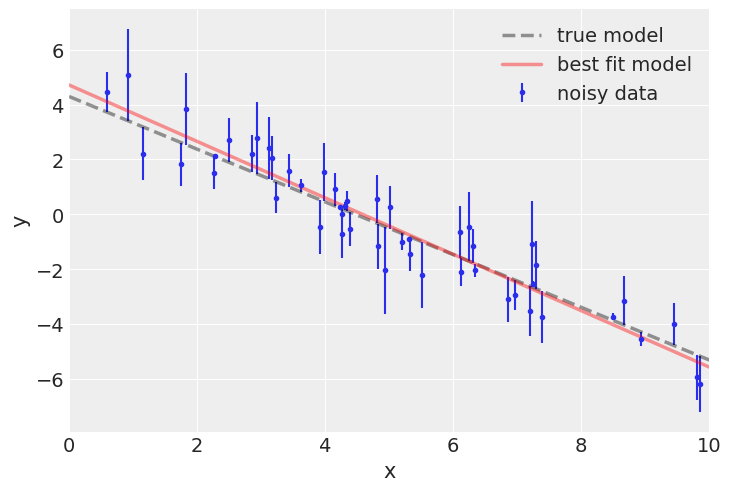

Best fit line: y=-1.0271x + 4.7128
True line: y=-0.9594x + 4.2940


In [35]:
# we could have defined this function earlier, but we need to do so now in order to use 
# scipy's curve fitting routine
def line(x, m, b):
    """Return a line of the form y=mx+b"""
    return m * x + b

# Find best fit values using curve_fit
popt, pcov = scipy.optimize.curve_fit(line, x, y)

# Plot our results for comparison
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0, label="noisy data")
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, 'k--', alpha=0.4, lw=2.5, label='true model')
plt.plot(x0, line(x0, *popt), 'r-', alpha=0.4, lw=2.5, label='best fit model')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

print(f"Best fit line: y={popt[0]:.4f}x + {popt[1]:.4f}")
print(f"True line: y={m_true:.4f}x + {b_true:.4f}")

As you can see, the "best fit" line using a least squares method is pretty close to the real values, but they don't match exactly! This is due to the random noise in the data, which in the real world typically comes from uncertainties and errors in our measurements. But how likely is this fit vs the true model to have actually generated this data? MCMC to the rescue! We'll now repeat the fitting process, but with MCMC using pyMC3 instead. 

In [64]:
basic_model = pm.Model()

with basic_model:
    # Priors
    # setting testval is like setting p0 in emcee
    # it is not strictly necessary, but may help chains converge quicker.
    # In this case, we'll use Uniform priors, but you can use other provided distributions
    # as priors as appropriate. 
    m_prior = pm.Uniform("m", lower=-10, upper=10) 
    b_prior = pm.Uniform("b", lower=-10, upper=10)
    
    # Expected value of outcome
    mu = m_prior * x + b_prior
    # Measurement uncertainty, sign doesn't matter and sigma must be positive for likelihood
    sigma = np.abs(yerr)

    # Likelihood of observations
    # What separates likelihood from priors in pyMC3 is the 'observed=' kwarg
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)


In [65]:
with basic_model:
    # Now for the MCMC itself. In this case, we are use the No U-Turn Sampler (NUTS).
    # This is one of the predefined samplers that comes with 
    step = pm.NUTS()
    # draw 1000 posterior samples using 12 different chains
    trace = pm.sample(2000, tune=2000, step=step, chains=12, discard_tuned_samples=True, return_inferencedata=False)

Multiprocess sampling (12 chains in 4 jobs)
NUTS: [b, m]


Sampling 12 chains for 2_000 tune and 2_000 draw iterations (24_000 + 24_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8898785764798472, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/spencerscott/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


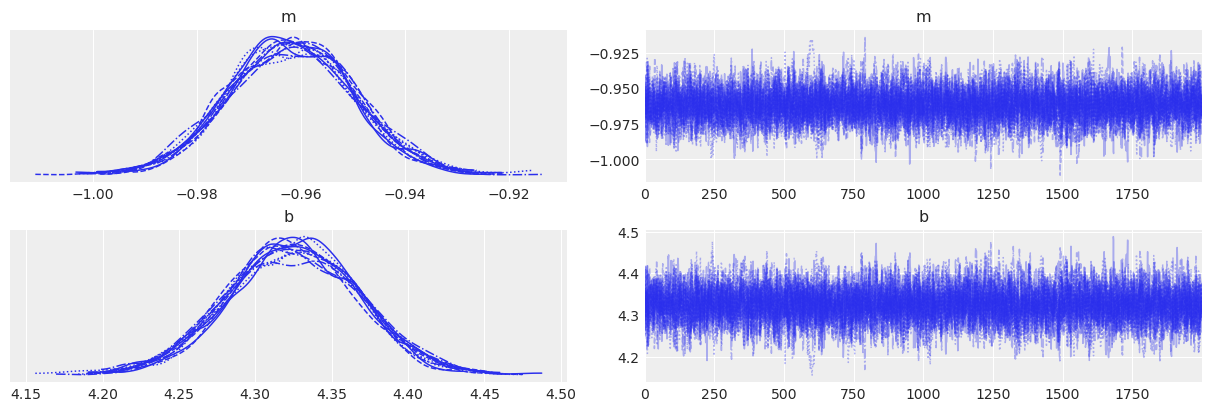

In [66]:
# plot our results using arviz
az.plot_trace(trace);

In [67]:
# retrieve inference data from the trace object pyMC returned
with basic_model:
    inference_data = az.from_pymc3(trace)
inference_data.median() # use median values of walkers as "best fit"

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data